In [ ]:
import dolphindb as ddb
# 连接 DolphinDB 数据库
s = ddb.session()
s.connect("********", '*****', '*******', '*******')
query ='''// 1. 加载数据库和表
db = database("dfs://YesLab")
fm = loadTable(db, "financial_metrics_table")   // 财务表
sfd = loadTable(db, "stock_factor_daily")       // 日线因子表
si = loadTable(db, "stock_info_table")          // 股票信息表

result = select 
    a.trade_date,      // 交易日期
    a.ts_code,         // 股票代码
    b.name,            // 股票名称
    b.industry,        // 所属行业
    b.market,           // 所属市场 (主板/创业板等)
    a.total_mv,
    a.pe              // 来自日线表的 PE 值 
from sfd as a 
left join si as b on a.ts_code = b.ts_code
where a.trade_date= 2016.04.29
    and isValid(a.pe)
order by a.trade_date, a.ts_code

// 2. 预处理财务表：过滤有效记录 + 转换日期类型
fm_clean = select 
    ts_code,
    date(ann_date) as date_ann,   // 字符串转日期
    roic                          // ROIC 
from fm 
where update_flag = 1 and isNull(ann_date) = false

// 3. 获取2017年所有唯一的交易日（按股票代码+交易日排序）
trading_days = select distinct ts_code, trade_date 
               from sfd 
               where trade_date =2016.04.29
order by ts_code, trade_date

// 4. 替代aj()的核心逻辑：匹配最近的财报数据
// 4.1 先关联所有"公告日 ≤ 交易日"的组合
tmp_joined = select 
    td.ts_code,
    td.trade_date,
    fm.date_ann,
    fm.roic
from trading_days as td
left join fm_clean as fm on td.ts_code = fm.ts_code
where fm.date_ann <= td.trade_date or isNull(fm.date_ann)

// 4.2 按股票代码+交易日分组，取每组内公告日最新的一条（即最近的财报）
fm_daily = select 
    ts_code,
    trade_date,
//    last(date_ann) as date_ann,  // 取最新的公告日
    last(roic) as roic           // 取对应公告日的ROIC
from tmp_joined
group by ts_code, trade_date
order by ts_code, trade_date

pe_roic = select 
    a.*,  // 保留t1所有列
    b.roic  // 从t2取需要的列
from result as a
left join fm_daily as b on a.trade_date = b.trade_date and a.ts_code = b.ts_code
pe_roic '''
result = s.run(query)

In [42]:
import pandas as pd
import numpy as np
def magic_formula(year):
    data=pd.read_excel(r'data/pe_roic/pe_roic_{}.xlsx'.format(year))
    data=data[(data['pe']>0) & (data['roic']>0)&    (data['total_mv']>data['total_mv'].quantile(0.1))]#剔除pe和roic为负数的股票以及市值过小的股票
    rank_pe=data['pe'].rank(method='average')
    rank_roic=data['roic'].rank(ascending=False,method='average')#倒序排列
    rank_used=rank_pe+rank_roic
    rank_used=pd.DataFrame(rank_used,columns=['rank'])
    new_data=pd.merge(data,rank_used,left_index=True,right_index=True)
    new_data.sort_values(by='rank',inplace=True)
    new_data.reset_index(drop=True,inplace=True)
    final_choice=new_data.iloc[:30,:]
    final_codes=list(final_choice['ts_code'].values)

    portfolio_return = calc_portfolio_return(year, final_codes)

    return final_codes,portfolio_return


    #接下来对每一年选出来的股票进行回测，计算每只股票在未来一年的收益率，并对这些股票的收益率进行平均，得到每一年的组合收益率
def calc_portfolio_return(select_year, stock_codes):
    """
    批量查询DolphinDB，计算选股后下一年的组合平均日度收益率
    :param select_year: 选股年份（如2016）
    :param stock_codes: 选中的股票代码列表
    :return: 组合平均日度收益率
    """
    # 定义回测时间区间：选股年份的下一年（完整自然年）
    backtest_start = f"{select_year}.04.30"
    backtest_end = f"{select_year + 1}.04.30"
    
    # DolphinDB 批量查询脚本（核心：一次性筛选所有股票，分组计算）
    dolphindb_script = """
        db = database("dfs://YesLab")
        sfd = loadTable(db, "stock_factor_daily")
        // 1. 批量筛选股票+时间，自动匹配时间分区，假设每只股票投资比例相同
        select_result = select 
                            ts_code,
                            last(close) / first(close) - 1 as stock_cum_return  // 单只股票年度总收益率
                        from sfd
                        where ts_code in {stock_codes}
                          and trade_date between date('{start}') : date('{end}')
                        group by ts_code
        // 2. 计算组合整体平均收益率
        portfolio_avg = avg(select_result.stock_cum_return)
        // 返回结果（兼容空值：无数据时返回0）
        iif(isNull(portfolio_avg), 0, portfolio_avg)
    """.format(
        stock_codes=stock_codes,  # DolphinDB 支持直接传入Python列表
        start=backtest_start,
        end=backtest_end
    )
    try:
        # 运行脚本并获取结果
        portfolio_return = s.run(dolphindb_script)
        return portfolio_return
    except Exception as e:
        # 打印错误信息，方便排查
        print(f"DolphinDB执行失败：{str(e)}")
        return np.nan  # 出错时返回空值


In [43]:
magic_code = pd.DataFrame()
revenue_dict = {}
for year in range(2010, 2026):
    formula_result = magic_formula(year)
    stock_codes = formula_result[0]
    year_profit = formula_result[1]
    magic_code[year] = stock_codes
    revenue_dict[year] = year_profit

# 按magic_code的列顺序（2010,2011,...2025）提取利润，保证列对齐
profit_values = [revenue_dict[col] for col in magic_code.columns]
# 构造利润行（行名='利润'，值=对应年份的利润）
profit_row = pd.Series(
    profit_values,
    index=magic_code.columns,  # 和magic_code的列完全一致，确保对齐
    name='profit'  # 利润行的名称
)

# 将利润行追加到magic_code的最后一行
magic_code = pd.concat([magic_code, profit_row.to_frame().T])

# ===================== 4. 输出到Excel =====================
# 保存到指定路径（建议用绝对路径，避免路径问题）
magic_code.to_excel(r'data/final_choice.xlsx')

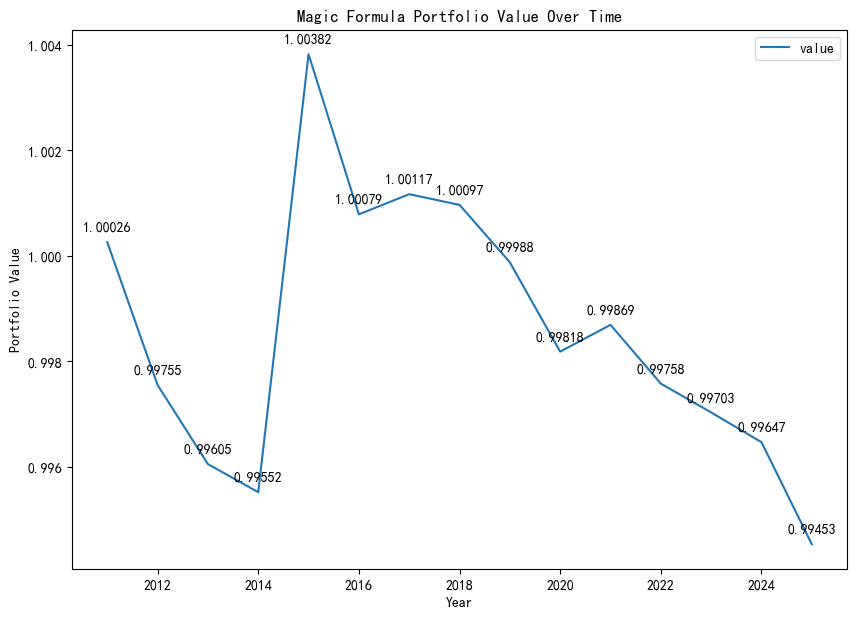

In [44]:
import matplotlib.pyplot as plt
value_list=[]
for year in range(2011,2026):
    value=1
    for i in range(2010,year):
        value=value*(revenue_dict[i]/100+1)
    value_list.append(value)
value_list=pd.DataFrame(value_list,index=range(2011,2026),columns=['value'])
ax=value_list.plot(title='Magic Formula Portfolio Value Over Time', ylabel='Portfolio Value', xlabel='Year', figsize=(10,7))
for x, y in zip(value_list.index, value_list['value']):
    ax.annotate(f'{y:.5f}',  # 保留5位小数
                (x, y),
                textcoords="offset points",
                xytext=(0, 8),  # 文字在点的上方8个像素
                ha='center')    # 水平居中

plt.show()

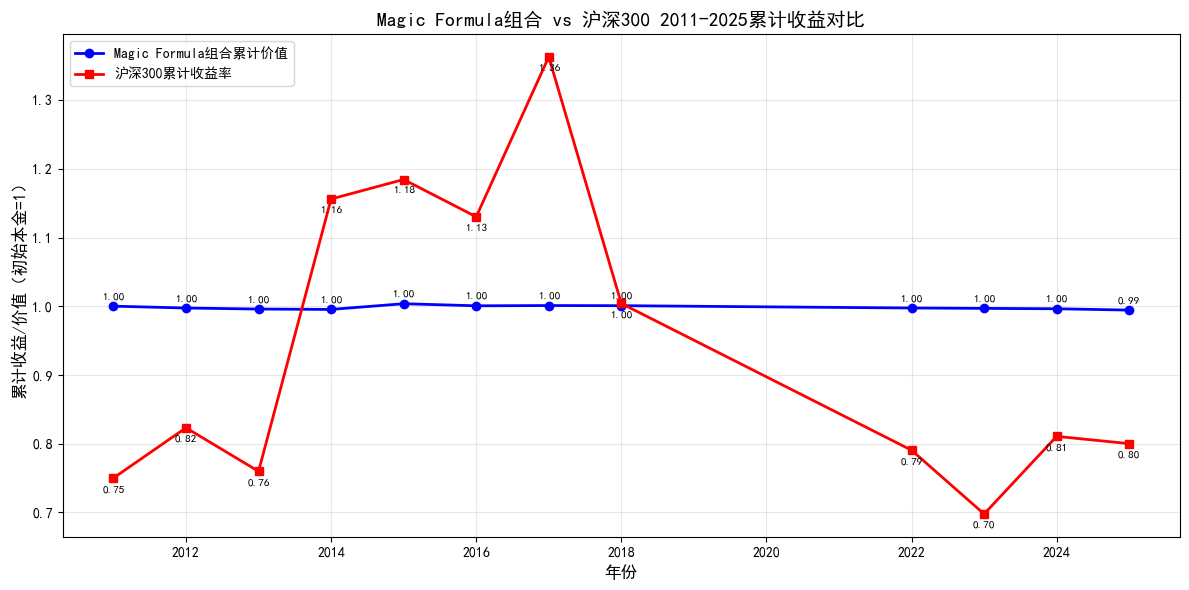

累计收益对比表（2011-2025）：
      magic_formula_cumulative  hs300_cumulative
2011                  1.000259          0.750016
2012                  0.997551          0.823165
2013                  0.996051          0.759780
2014                  0.995520          1.156273
2015                  1.003822          1.184680
2016                  1.000787          1.130386
2017                  1.001169          1.363290
2018                  1.000966          1.004157
2022                  0.997577          0.790548
2023                  0.997031          0.697666
2024                  0.996467          0.810682
2025                  0.994533          0.800109


In [45]:
# ---------------------- 2. 查询沪深300每日数据并计算累计收益率 ----------------------
query1 = '''
// 1. 连接数据库并加载表（替换为你的实际库名/表名）
db = database("dfs://YesLab")
id = loadTable(db, "index_daily_data")  // 确保表中有 ts_code/trade_date/pct_chg/close 字段

// 2. 第一步：查询基础数据（过滤时间和股票）
base_data = select
    ts_code,
    trade_date,
    year(trade_date) as trade_year,
    pct_chg,
    close
from id
where ts_code = '000300.SH' and trade_date between date('2010.04.30') : date('2025.04.30')
order by trade_date asc;  

// 3. 计算年度累计收益率（按年分组，便于和原有数据对齐）
yearly_return = select
    trade_year,
    last(close)/first(close) - 1 as yearly_close_return
from base_data
group by trade_year
order by trade_year asc;

yearly_return = select * from yearly_return where trade_year between 2010 : 2025;
// 4. 计算累计收益率（从2010年开始复利计算）
yearly_return = select *, 
    cumprod(1 + yearly_close_return) as cumulative_return  // 累计复利
from yearly_return;

yearly_return
'''

# 执行查询并处理结果
result1 = s.run(query1)
# 转换为DataFrame并整理索引
hs300_df = pd.DataFrame({
    'year': result1['trade_year'],
    'yearly_return': result1['yearly_close_return'],
    'cumulative_return': result1['cumulative_return']
}).set_index('year')

# ---------------------- 3. 原有Magic Formula组合价值数据 ----------------------
# 计算Magic Formula组合累计价值
value_list = []
for year in range(2011, 2026):
    value = 1  # 初始本金1
    for i in range(2010, year):
        value = value * (revenue_dict[i] / 100 + 1)
    value_list.append(value)

# 整理为DataFrame（索引和沪深300对齐）
mf_df = pd.DataFrame(
    value_list, 
    index=range(2011, 2026), 
    columns=['magic_formula_cumulative']
)

# ---------------------- 4. 合并数据并绘制对比图 ----------------------
# 对齐索引（只保留2011-2025年的交集）
merged_df = pd.merge(
    mf_df,
    hs300_df[['cumulative_return']].rename(columns={'cumulative_return': 'hs300_cumulative'}),
    left_index=True,
    right_index=True,
    how='inner'
)

# 绘制双折线对比图
plt.rcParams['font.sans-serif'] = ['SimHei']  # 解决中文显示问题
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

fig, ax = plt.subplots(figsize=(12, 6))

# 绘制Magic Formula组合价值
ax.plot(merged_df.index, merged_df['magic_formula_cumulative'], 
        label='Magic Formula组合累计价值', color='blue', marker='o', linewidth=2)

# 绘制沪深300累计收益率（注意：累计收益率是相对值，可乘以1方便对比）
ax.plot(merged_df.index, merged_df['hs300_cumulative'], 
        label='沪深300累计收益率', color='red', marker='s', linewidth=2)

# 在每个数据点标注数值
for x, y in zip(merged_df.index, merged_df['magic_formula_cumulative']):
    ax.annotate(f'{y:.2f}', (x, y), xytext=(0, 5), textcoords='offset points', ha='center', fontsize=8)

for x, y in zip(merged_df.index, merged_df['hs300_cumulative']):
    ax.annotate(f'{y:.2f}', (x, y), xytext=(0, -10), textcoords='offset points', ha='center', fontsize=8)

# 设置图表样式
ax.set_title('Magic Formula组合 vs 沪深300 2011-2025累计收益对比', fontsize=14)
ax.set_xlabel('年份', fontsize=12)
ax.set_ylabel('累计收益/价值（初始本金=1）', fontsize=12)
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 打印最终对比数据
print("累计收益对比表（2011-2025）：")
print(merged_df)